# Charged Runs (clean up)

Here we go through the steps to do a simple charged run:

# Initializations

In [1]:
from ringdb import Database
import ringdown
import numpy as np
import pandas as pd
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Only needed by mac
import multiprocessing
#multiprocessing.set_start_method('fork') (run this once only)

In addition, just run the cell below. This defines:
- the database
- functions:
    - `get_target`: produces target arguments by finding the t_peak at geocent for a subset of posterior samples
    - `set_fit`: produces The fit object given some parameters of the run we want to do 

In [4]:
# Set up database
data_folder = "./Data" # Folder where the downloaded strain data is saved

db = Database(data_folder)
db.initialize()

db.update_posterior_schema({'f_low': {'path': "/{approximant}/meta_data/meta_data/f_low", 'type':'value'}})
db.update_posterior_schema({'f_ref': {'path': "/{approximant}/meta_data/meta_data/f_ref", 'type':'value'}})


# Define functions
def get_target(eventname, N_samps=None, target_sample_rate=4096, f_low=20, f_ref=20, q=0.5):
    """
    Calculates the sky location and start time that will be chosen for the fit object. 
    This function will 
    1. randomly get a subset posterior samples (of size `N_samps`)
    2. calculate the geocenter peak strain for each of the posterior samples
    3. choose the `q`-th quantile (i.e. `q*100`-th percentile) sample and package its t0, ra, dec and psi 
    
    
    Parameters
    -----------
    eventname : str
        The name of the event e.g. "GW150914"
    N_samps : int
        This many samples will be chosen from the posterior for the actual analysis. Some IMR posteriors have too many samples.
        Defaults to using all samples
    target_sample_rate : float
        The waveform generator will use this sample rate when generating waveforms
    f_low : float (default : 20)
        f_low
    f_ref : float (default : 20)
        reference frequency
    q :  float (default : 0.5)
        The chosen sample for the target will be the one which lands on the `q`-th quantile when ordered by the geocent peak time. 
        
        
    Returns
    --------
    args : Dict with keys 't0', 'ra', 'dec' and 'psi' 
        This is a dictionary of the chosen target parameters.
    median_samp : pd.Series
        This is the chosen median sample. Returned if any other parameters like final_mass and final_spin are needed. 
    samps : pd.DataFrame
        A dataframe of all the samples that were chosen for calculation and their corresponding peak times at each ifo.
    
    """
    event = db.event(eventname)
    strains = event.strain()
    posts = event.posteriors()

    N_samps = N_samps or len(posts)

    try:
        f_low = float(event.read_posterior_file_from_schema('f_low'))
        f_ref = float(event.read_posterior_file_from_schema('f_ref'))
        waveform_name = posts['waveform_name'].unique()[0]
        waveform_code = int(posts['waveform_code'].unique()[0])
    except:
        print("Falling back to f_ref = 20, f_low=20")
        waveform_name = posts['waveform_name'].unique()[0]
        waveform_code = int(posts['waveform_code'].unique()[0])
        f_low = f_low
        f_ref = f_ref


    print(f"Using {waveform_name}")
    wf_ls = waveform_code
    sample_rate = np.max([a.fsamp for a in strains.values()])


    samps = [x.to_dict() for i,x in posts.sample(N_samps).iterrows()]

    for i,x in enumerate(samps):
        t_peak, t_dict, hp, hc = ringdown.complex_strain_peak_time_td(x,
                                                                      wf=wf_ls, dt=1/target_sample_rate,
                                                                      f_ref=f_ref, f_low=f_low)
        samps[i].update({k+'_peak':v for k,v in t_dict.items()})

    samps = pd.DataFrame(samps)

    # Get median sample
    ref_ifo = 'H1'
    im = (samps[f'{ref_ifo}_peak'] - samps[f'{ref_ifo}_peak'].quantile(q)).abs().argmin()
    median_samp = samps.iloc[im]

    # Construct Arguments for set_target
    args = median_samp[['geocent_peak', 'ra','dec','psi']].rename({'geocent_peak':'t0'}).to_dict()
    print("The median time at H1 is: ", median_samp['H1_peak'], "s")

    # Get the mass time-scale
    Mass_Time = lambda M: 6.674e-11*M*1.989e+30/(3e8)**3
    t_M = Mass_Time(median_samp['final_mass'])
    print("The mass time-scale is: ", np.round(t_M*1000,3), "ms")

    times_above_below = (samps['H1_peak'].quantile(0.95) - samps['H1_peak'].quantile(0.05))/(2*t_M)
    print(f"The 90% CI of H1 peak time is +/- {np.round(times_above_below,1)} t_M")

    return args, median_samp, samps

def set_fit(eventname, target, mass_for_prior, duration=0.1, target_sample_rate=4096, model='mchiq_exact', modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)], cond_kws = None, **model_kwargs):

    '''
    The convention for modes is (prograde, s, l, m, n)
    The options for models are mchi, mchiq, and mchiq_exact. 
    mchiq is for all beyond-GR EVP applications.
    You can change the beyon-GR model using the kwargs, which get passed to ringdown.Fit
    The coefficients must be created by fitting EVP data as a separate step.
    df_coeffs = [[a0,a1,a2,a3...],[a0,a1,a2,a3...],..]; n_modes x n_coeffs for the frequency shifts
    dg_coeffs = (similar structure as df) for the decay rate shifts
    '''
    
    event = db.event(eventname)
    strains = event.strain()
    
    #Hacking in ability to change amplitude priors:
    #Aprior = model_kwargs.pop('flat_A',1)
    
    fit = ringdown.Fit(model=model, modes=modes, **model_kwargs)
    
    for ifo in strains.keys():
        fit.add_data(strains[ifo])
        
    sample_rate = np.max([f.fsamp for f in strains.values()])

    fit.set_target(**target, duration=duration)
    
    #Adding a cond kwargs to allow us to low pass or add other conditioning arguments
    default_kws = dict(digital_filter=True, trim=0.0)
    default_kws.update(cond_kws or {})
    
    #Revisit the trim = 0 setting. Why was this done? Naively this should be set to a nonzero value

    fit.condition_data(ds=int(sample_rate/target_sample_rate),**default_kws)
    fit.compute_acfs()

    #fit.update_prior(A_scale=5e-21, M_min=mass_for_prior*0.5,
    #                 M_max=mass_for_prior*2.0,
    #                 flat_A=1)
    fit.update_prior(A_scale=5e-21, M_min=mass_for_prior*0.5,
                     M_max=mass_for_prior*2.0,
                     flat_A=1)
    return fit

# Procedure

__1. Set the event we want to work with:__

In [7]:
eventname = "GW150914" # Name of the event

__2. Compute the target:__

In [8]:
args, median_samp, samps = get_target(eventname=eventname,  # name of the event
                                      N_samps=800, # size posterior samples subset used for this computation  
                                      q=0.5)        # the sample with the q*100 % percentile sample is picked out) 

Using IMRPhenomXPHM
The median time at H1 is:  1126259462.4241242 s
The mass time-scale is:  0.317 ms
The 90% CI of H1 peak time is +/- 5.0 t_M


__3. Model Selection:__

Here we also choose the type of analysis we would like to do. The options include:

1. `mchi`:  A ringdown model which infers $M$ and $\chi$ based off of Kerr QNMs
2. `mchiq`:  A ringdown analysis which infers $M$, $\chi$ and $q$. This assumes a model for QNMs which are shifted at first order by $\omega_i \sim \omega^{Kerr}_i + q \delta\omega_i(\chi)$. Where:

$$
\delta f_i = \alpha_{-1}\chi + \alpha_{0} + \alpha_{1}\log(1-\chi) + \alpha_{2}\log^{2}(1-\chi) + \alpha_{3}\log^3(1-\chi) + \alpha_{4}\log^4(1-\chi) \\
\delta \gamma_i = \beta_{-1}\chi + \beta_{0} + \beta_{1}\log(1-\chi) + \beta_{2}\log^{2}(1-\chi) + \beta_{3}\log^3(1-\chi) + \beta_{4}\log^4(1-\chi)
$$

for some user defined coefficients `df_coeffs = [a_i...]` and `dg_coeffs = [b_i...]`

__Note__ _however that for now `mchiq` uses priors where $(\chi,\sqrt{q})$ lie in a quadrant like in the charged case._ I need to change that. I hope to make a new one called `mchi_shifted` that just infers some expansion parameter $\epsilon$ with completely uninformed priors there. 

3. `mchiq_exact`: A ringdown model that uses the numerical interpolation given in [__insert the Carulo paper__] to give the exact Kerr Newmna QNMs. 

We will for our charged hierarchical analysis paper just use `mchi` and `mchiq_exact`

In [9]:
model = 'mchi'   # Choose one of `mchi`, `mchiq` (needs extra parameters below), `mchiq_exact`

__3. Set the fit object:__

In [11]:
fit = set_fit(eventname = eventname,                          # Name of the event e.g. "GW150914"
              target = args,                                  # Dictionary of target arguments t0, ra, dec & psi
              mass_for_prior = median_samp['final_mass'],     # Provide a mass M -  the mass prior will be [0.5M, 1.5M]
              duration = 0.03,                                 # Duration of the strain segment for analysis
              target_sample_rate = 4_096,                     # The sample rate of the segment you would like for final analysis
              model = model,                                   # Choose one of `mchi`, `mchiq` (needs extra parameters below), `mchiq_exact`
              modes = [(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)],    # Modes (p,s,l,m,n)
              cond_kws={'flow':20.0}                            # Add any keywords to the data.condition() function. In this case we low pass at 20 Hz
             # Additional Args (only viable for mchiq which works for general first orderr shifts): 
             # df_coeffs = [[a0,a1,a2,a3...],[a0,a1,a2,a3...],..]; n_modes x n_coeffs for the frequency shifts
             # dg_coeffs = similar to above
             )

__5. Run the fit object:__

In [12]:
fit.run()

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, Apx_unit, Apy_unit, Acx_unit, Acy_unit, df, dtau]
INFO:pymc:NUTS: [M, chi, Apx_unit, Apy_unit, Acx_unit, Acy_unit, df, dtau]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.


__6. Put the data into a Posterior object.__

In [31]:
from HierarchicalKerrNewman.Posterior import Posterior, ChargedPosterior

if 'q' not in model:
    test_cf = Posterior(eventname, inference_data=fit.result) # Use Posterior if uncharged analysis
else:
    test_cf = ChargedPosterior(eventname, inference_data=fit.result) # Use Charged Posterior if uncharged analysis

__7. (*Optional*) Save posteriors to disk, and then reload it into a posterior object__

In [32]:
filename = f"../Results/{eventname}-charged.nc"

In [33]:
fit.result.to_netcdf(filename) # Save to disk

'../Results/GW190521-charged.nc'

__Reloading Checkpoint (RUN ONLY IF YOU WANT TO LOAD A POSTERIOR FROM FILE AND MOVE ON)__

In [12]:
eventname = "GW190521"
model = "mchiq_exact"
filename = f"../Results/{eventname}-charged2.nc"

if 'q' not in model:
    test_cf = Posterior(eventname, filename=filename) # Use Posterior if uncharged analysis
else:
    test_cf = ChargedPosterior(eventname, filename=filename) # Use Charged Posterior if charged analysis

# Plots

We can use this object to make lots of plots and then think deep things about said plots:


### $M$ vs $\chi$ compared to IMR posteriors

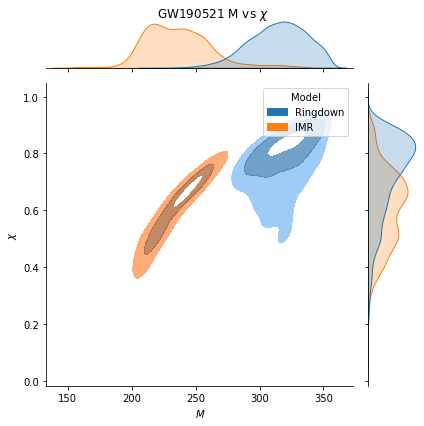

In [34]:
event = db.event(eventname)
IMRs = event.posteriors()

test_cf.M_chi_plot(IMR=IMRs.sample(8000))
plt.show()

# $\chi$ vs $Q$
The following only work for `ChargedPosteriors`

### $\chi$ vs $Q$ hexbin

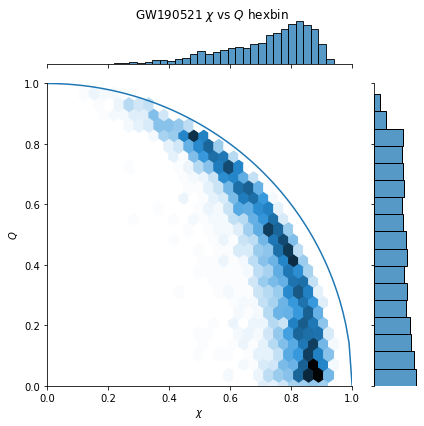

In [35]:
test_cf.chi_q_plot_hexbin()

### $\chi$ vs $Q$ simple KDE

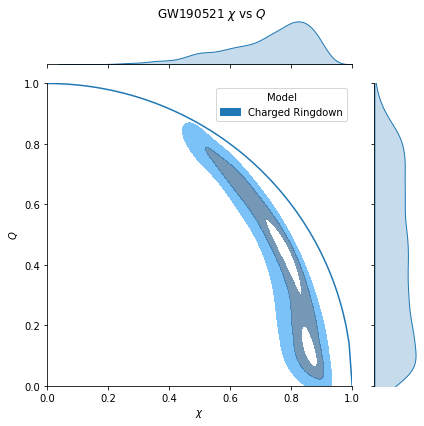

In [36]:
test_cf.chi_q_plot()

### $\chi$ vs $Q$ bounded KDE

The plot for this one is constructed by using Kernels in $r$-$\theta$ space and then converting the resulting function back to $\chi$ vs $Q$.

<AxesSubplot:title={'center':'Bounded KDE plot for GW190521'}, xlabel='$\\chi$', ylabel='$Q$'>

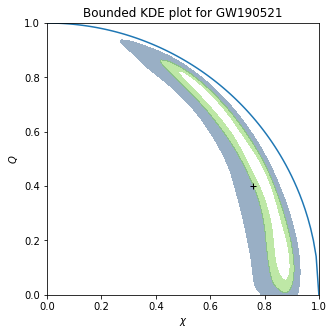

In [37]:
test_cf.chi_q_plot_bounded()

# Resampling to get Likelihood

# Initializations

Here we take our resultant charged posterior and divide out the prior in $Q$-$\chi$. 

The following function will take in $r-\theta$ samples as a dataframe and resample them with the weight 1/r. In particular the keyword `oversampling` tells us how many more output samples will be produced compared to the size of the provided samples (#output samples = oversampling x #input samples)

In [38]:
from HierarchicalKerrNewman.MixtureModel import MixtureModel

def Resample(data : pd.DataFrame, oversampling = 100):
    """
    Take in $r-\theta$ samples as a dataframe and resample them with the weight 1/r. 
    In particular the keyword `oversampling` tells us how many more output samples will 
    be produced compared to the size of the provided samples 
    (#output samples = oversampling x #input samples)
    
    Arguments
    ----------
    data : pd.DataFrame
        data we want to resample
    oversampling : int (default : 100)
        number of output samples = oversampling x (number of input samples)
        
    Returns
    --------
    pd.DataFrame
        A dataframe of the reweighted samples with the columns ['Q_charge','chi', 'r','theta']
    """
    N = len(data.index)
    weights = (1/data['r']).values
    weights = weights/np.sum(weights)
    M = int(N*oversampling)
    reweighted_indices = np.random.choice(N,M,p=weights)
    return data[['Q_charge','chi', 'r','theta']].iloc[reweighted_indices,:]
   

## Procedure 

__1. Resample the posterior samples to get likelihood samples__

In [39]:
resampled_data = Resample(test_cf.data)

We can then create a MixtureModel object which can do the Gaussian Mixture Model fit, and then help us verify the fit using plots

__2. Create a mixture model object for the likelihood and fit it__

In [40]:
likelihood_gmm = MixtureModel(data=resampled_data[['r','theta']],   # Use the reweighted samples samples
                 kernel_space = ['r','theta'],      # The kernels should exist in the r-theta plane
                 truncation=[[0,1],[0,np.pi/2]],    # We assume the truncation $r \in (0,1), \theta \in (0,\pi/2)$
                 correlated=False,                  # We will allow kernels to be seperable in r and theta
                 n_components=30)                   # We will use 30 kernel components

# We fit the data:
likelihood_gmm.fit()

__3. Compare both Posterior and Likelihood__

Let's also have a look at the gmm fit of the posterior samples themselves:

In [41]:
posterior_gmm = MixtureModel(data=test_cf.data.sample(len(resampled_data.index), replace=True)[['r','theta']],   # Use the oversampled posterior samples
                 kernel_space = ['r','theta'],      # The kernels should exist in the r-theta plane
                 truncation=[[0,1],[0,np.pi/2]],    # We assume the truncation $r \in (0,1), \theta \in (0,\pi/2)$
                 correlated=False,                  # We will allow kernels to be seperable in r and theta
                 n_components=30)                   # We will use 30 kernel components

# We fit the data:
posterior_gmm.fit()

### Comparison of Posterior and Likelihood Samples

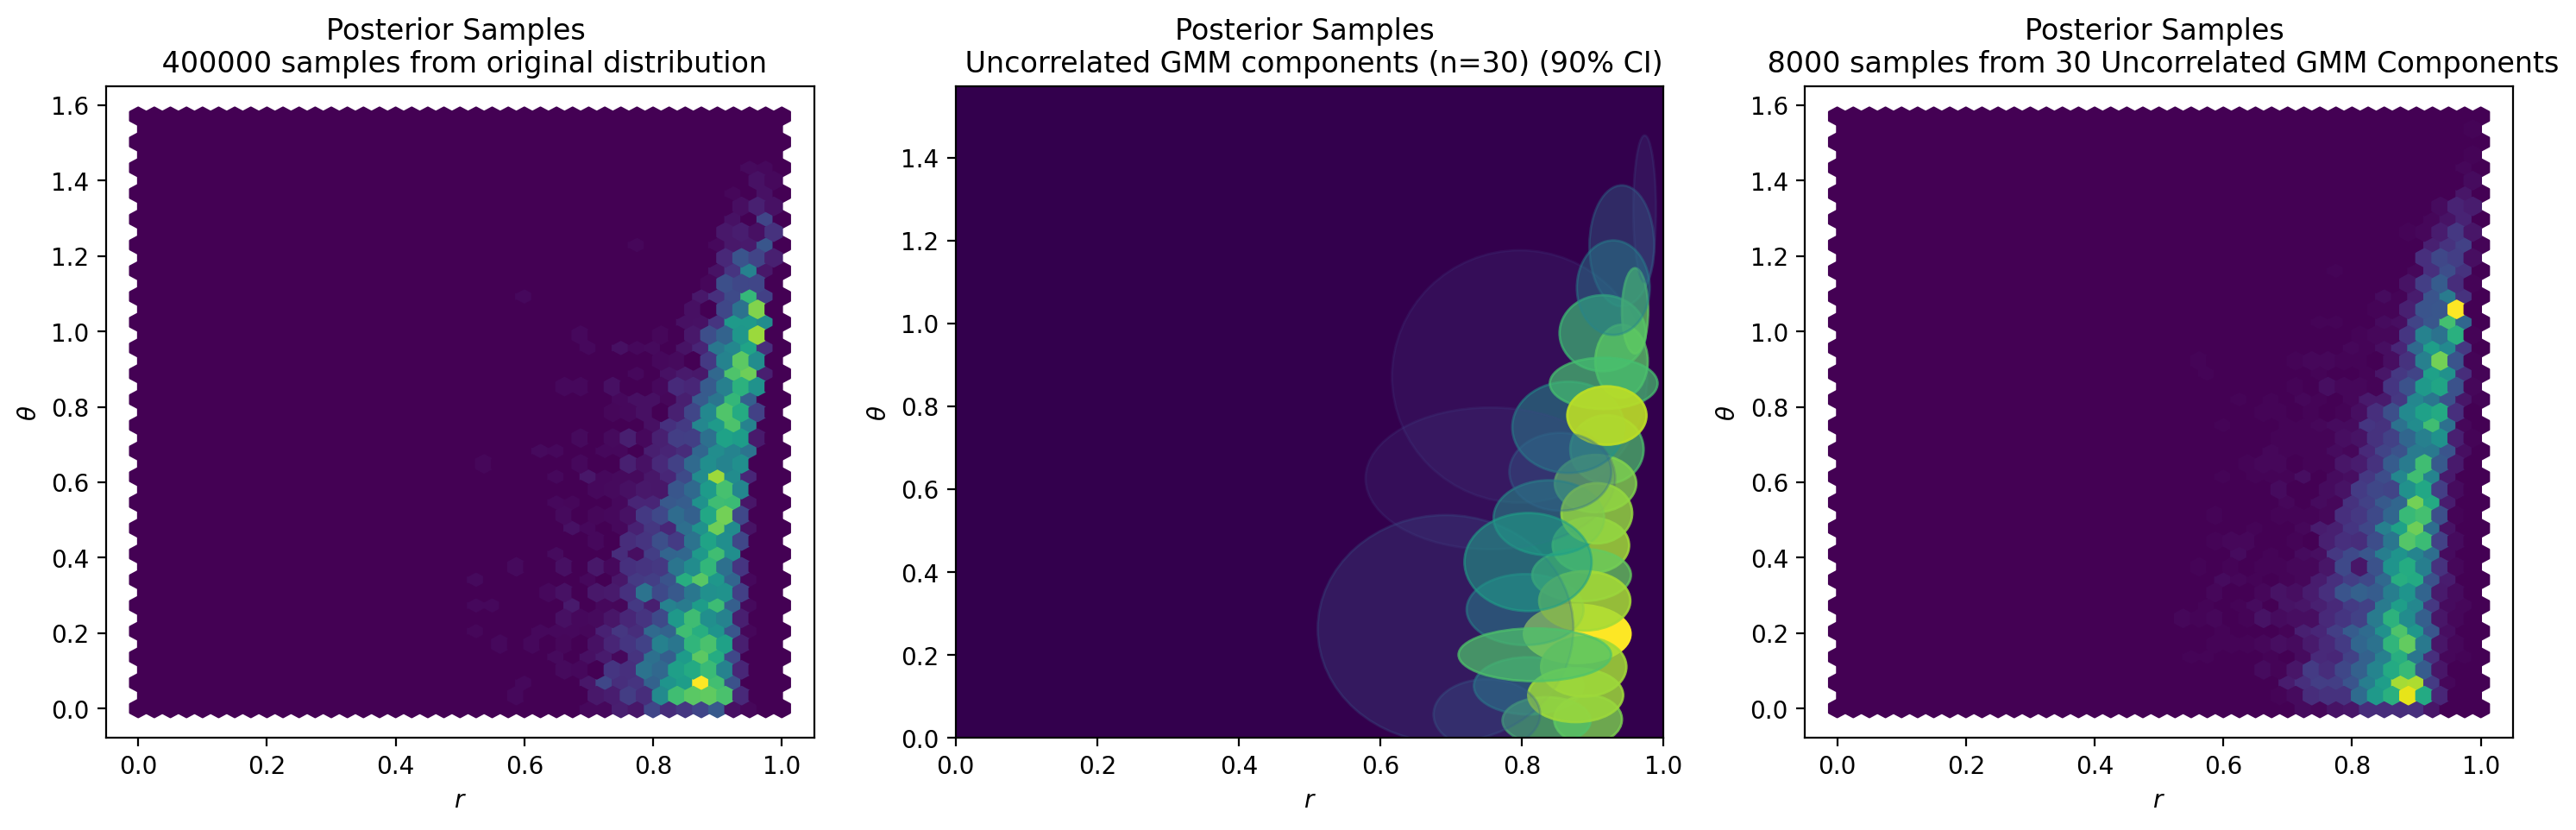

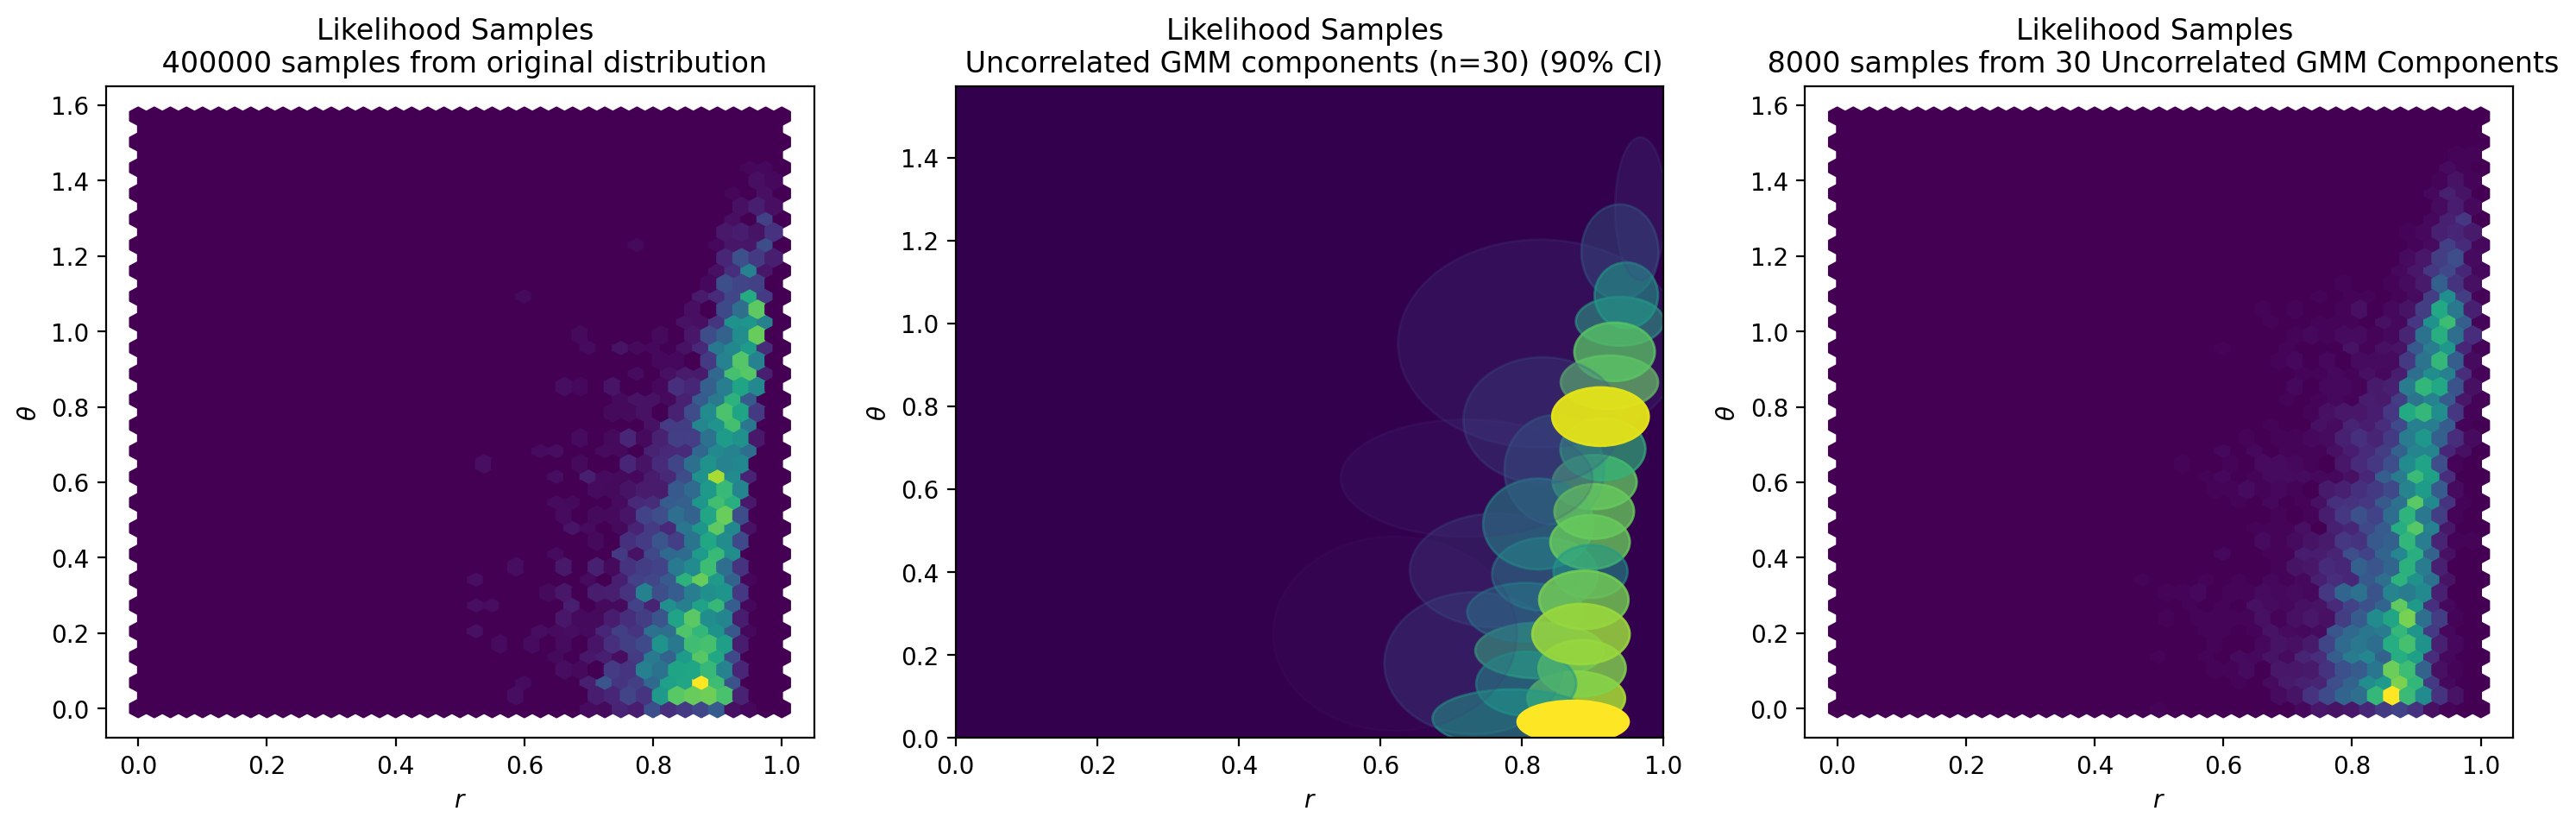

In [42]:
posterior_gmm.plot_comparison(name="Posterior Samples", gridsize=40,nsamps=8000, dpi=200)
likelihood_gmm.plot_comparison(name="Likelihood Samples", gridsize=40,nsamps=8000, dpi=200)